# Project 2 - COSC 528
## October 22, 2018
## Author: Ian R. Stewart

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy.linalg import svd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
inPath = '/Users/i6o/Documents/COSC 528/Project 2/'
df = pd.read_excel(inPath+'UTK-peers.xlsx')

Dropping empty rows from imported file

In [3]:
first_row_with_all_NaN = df.shape[0]-df[df.isnull().all(axis=1) == True].shape[0]
df = df.loc[0:first_row_with_all_NaN-1]

Dropping unique features from dataframe

In [4]:
df = df.drop(['IPEDS#','HBC','Carm R1'],axis=1)

Searching for empty data entries in features

In [5]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print df.columns.values[indexes]

[u'2014 Med School' u'Vet School' u'Endowment' u'Wall St. Jourl Rank'
 u'Enowment / St. FTE' u'AG Research ($000)']


Inserting correct WSJ College Rankings from following reference: https://www.timeshighereducation.com/sites/default/files/breaking_news_files/wsj-the-college-rankings-2017-results.pdf

University with partial names, such 'Utah', were confirmed to be specific universities via the IPEDS number.

In [6]:
df['Wall St. Jourl Rank'][df['Name']=='Delaware']=137
df['Wall St. Jourl Rank'][df['Name']=='Colorado State']=353
df['Wall St. Jourl Rank'][df['Name']==' Arizona State']=131
df['Wall St. Jourl Rank'][df['Name']=='Georgia Tech']=51
df['Wall St. Jourl Rank'][df['Name']=='UC-Irvine']=153
df['Wall St. Jourl Rank'][df['Name']=='UC-San Diego']=49
df['Wall St. Jourl Rank'][df['Name']=='Connecticut']=110
df['Wall St. Jourl Rank'][df['Name']==' Iowa']=164
df['Wall St. Jourl Rank'][df['Name']=='Buffalo']=130
df['Wall St. Jourl Rank'][df['Name']=='Utah']=311
df['Wall St. Jourl Rank'][df['Name']=='UC-Riverside']=368
df['Wall St. Jourl Rank'][df['Name']==' Arizona']=162

In [7]:
df['2014 Med School'][df['2014 Med School']=='x']=1
df['2014 Med School'][df['2014 Med School']=='pre clin']=1
df['2014 Med School'][df['2014 Med School']!=int(1)]=0
df['Vet School'][df['Vet School']!='x']=0
df['Vet School'][df['Vet School']=='x']=1
df['Endowment'][df['Name']=='Clemson Univ.']=621.3E6

In [8]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: [u'Enowment / St. FTE' u'AG Research ($000)']


Error in feature label. Fixing typo of label "Enowment / St. FTE" to "Endowment / St. FTE"

In [9]:
df.rename(columns={"Enowment / St. FTE":"Endowment / St. FTE"},inplace=True)

Fixing NaN value in Endowment / St. FTE ; It should be noted that after checking the other values for this feature, the Endowment divided by St. FTE is *NOT* exactly the reported value in the provided data.

In [10]:
count = 0
for i in df["Endowment / St. FTE"]:
    j = str(i)
    if j == "nan":
        name = df['Name'][count]
        endowment = df['Endowment'][df['Name']==name]
        fte = df['ST. FTE'][df['Name']==name]
        df["Endowment / St. FTE"][df['Name']==name]=int(endowment / fte)
    count+=1

With many missing values and poor reporting for the AG (assume agricultural) research expenditures, the feature has been dropped from the analysis.

In [11]:
df = df.drop(['AG Research ($000)'],axis=1)

Re-verifying that all features have are filled with no missing data.

In [12]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: []


Fixing data types on manipulated data feautures.

In [13]:
df['Name']=df['Name'].astype('|S')
df['Vet School']=df['Vet School'].astype(float)
df['2014 Med School']=df['2014 Med School'].astype(float)

Now that the data has been explored with appropriate handling of the unique features and missing data, let's create a data matrix containing soley the numeric attributes for analysis.

In [14]:
analysis = df.iloc[:,1::] # Essentially, we are only dropping the university name

In [52]:
analysis.shape

(57, 60)

Mean-centering the data prior to analysis.

In [57]:
# Centering each data feature
a_centered=(analysis.iloc[:,0::]-analysis.iloc[:,0::].mean())

### **Analysis**

Finding factorized matrices from created analysis matrix. For the matrix **Analysis** with (*57x60*), the expected sizes of the factorized matrices are as follows: **U**(*57x57*), **Sigma**(*57x60*), and **VT**(*60x60*). Of note, the package utilized here (SciPy.linalg.SVD) outputs a single column (57-length vector) for **Sigma**, which is a diagonal matrix. These values are known as the singular values of the original matrix **Analysis**, while **U** and **VT** are referred to as the left-singular and right-singular vectors of **Analysis**, respectively.

In [58]:
U, Sigma, VT = svd(a_centered)

In [59]:
# Verifying shape of SVD from SciPy.linalg.SVD function
U.shape,Sigma.shape,VT.shape

((57, 57), (57,), (60, 60))

Now that the matrix decomposition is complete, we must find the optimal threshold for the number of dimensions to retain. To assist in making this decision, we can create a Scree plot to visualize the data. Of note, the variance is calculated by squaring the singular values (i.e. values in **Sigma** vector).

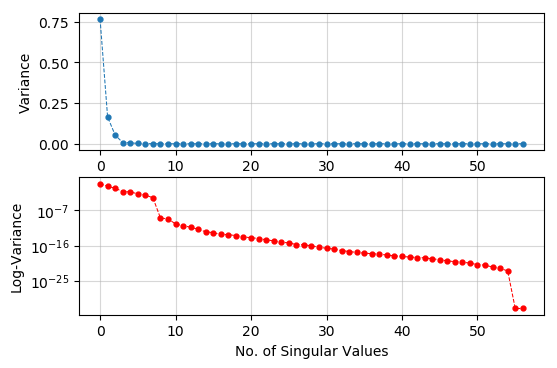

In [79]:
# Creating Scree plot
fig, (ax,ax1) = plt.subplots(nrows=2,dpi=100)
variance_sigma = Sigma**2/np.cumsum(Sigma**2)[-1]
ax.plot(variance_sigma,'o--',markersize=3.5,linewidth=0.75)
ax.grid(alpha=0.5)
ax.set_ylabel('Variance')
ax1.plot(variance_sigma,'ro--',markersize=3.5,linewidth=0.75)
ax1.set_ylabel('Log-Variance')
ax1.set_xlabel('No. of Singular Values')
ax1.set_yscale('log')
ax1.grid(which='both',alpha=0.5)


In [96]:
print 'Percentage of Variance by the first value:\t\t%.3f %%'%(np.sum(variance_sigma[0:1])*100)
print 'Percentage of Variance by the first two values:\t\t%.3f %%'%(np.sum(variance_sigma[0:2])*100)
print 'Percentage of Variance by the first three values:\t%.3f %%'%(np.sum(variance_sigma[0:3])*100)
print 'Percentage of Variance by the first four values:\t%.3f %%'%(np.sum(variance_sigma[0:4])*100)

Percentage of Variance by the first value:		76.625 %
Percentage of Variance by the first two values:		93.041 %
Percentage of Variance by the first three values:	98.380 %
Percentage of Variance by the first four values:	99.115 %


In [100]:
# The transpose of a transpose returns the original matrix

In [99]:
def getValues(n,V):
    

(60, 60)